# Grabing Yield data (wafer level) and PCM data for Specific Part and date range

In [1]:
##importing the needed libraries for data analysis.
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

## Connect to Oracle database and pull PCM data

In [2]:
import cx_Oracle

## make dsn from tns information (found in tnsnames.ora)
dsn_tns = cx_Oracle.makedsn('*******', '****', service_name='****') #if needed, place an 'r' before any parameter in order to address any special character such as '\'.
conn = cx_Oracle.connect(user='DCPCM', password='DCPCM', dsn=dsn_tns) #if needed, place an 'r' before any parameter in order to address any special character such as '\'. For example, if your user name contains '\', you'll need to place 'r' before the user name: user=r'User Name'


In [3]:
query="""SELECT MASK as Part, LOT, WAFER, FIELD_X, FIELD_Y, FIELD, R5 as TaN_25x2, TIMESTAMP as PARAM_date FROM *********** where TIMESTAMP > sysdate-60 and
test_level = 3960 and 
subcircuit =985 and 
test_iteration = '1' and 
MASK like '%ZM045%'"""

In [4]:
PCM=pd.read_sql(query, con=conn)

In [5]:
import datetime
End=datetime.datetime.now()
Start=End-datetime.timedelta(days=30)

In [6]:
## getting inputs from user for 1) Part name; 2) start and end dates
Part_Name="*****"

In [7]:
##file path for folder containing the wafer level yield summary reports for all products & all lots
File_Path="//************************************"

In [8]:
## list all files under File_Path
folderfiles=os.listdir(File_Path)

In [9]:
## select files only with a specific Part
selected_files=list(filter(lambda x: x.startswith(Part_Name), folderfiles))

In [10]:
##function to grab the last modified time of files.
def get_modification_time(file):
    t=os.path.getmtime(file)
    return time.ctime(t)

In [11]:
# Store the last modified time of selected files in Mod_time
Mod_time=[]

for file in selected_files:
    Mod_time.append(get_modification_time(File_Path+file))


In [12]:
## Create DataFrame with filename and Mod_time, filter to specified date range, store in DataFrame Files_of_interest
File_df=pd.DataFrame({'filename':selected_files,'Mod_time':Mod_time})
File_df['Mod_time']=pd.to_datetime(File_df['Mod_time'])
Files_of_interest=File_df[(File_df['Mod_time']>pd.to_datetime(Start)) & (File_df['Mod_time']<pd.to_datetime(End)) ]
Files_of_interest.reset_index(drop=True, inplace=True)

In [13]:
#Read the 1st lot yield data into df1
df1=pd.read_table(File_Path+Files_of_interest['filename'][0])

In [14]:
#Loop through the rest of lots in the list, i.e. Files_of_interest, append to df1.
for file in Files_of_interest['filename'][1:]:
    df1=pd.concat((df1, pd.read_table(File_Path+file)))

In [15]:
# strip spaces from column names
df1.columns=df1.columns.str.strip()

In [16]:
df1['Part']=df1['Rev'].apply(lambda x: x.split('_')[0])

In [17]:
#Create output df: Out_df
YE=df1[['Part','Lot','Wafer','Yield','Date','Time']]

In [18]:
YE['Probe_date']=pd.to_datetime('2019 '+ YE['Date'].str[:3]+' '+YE['Date'].str[3:]+' '+YE['Time'])
YE=YE[['Part','Lot','Wafer','Yield','Probe_date']]

In [19]:
YE.sort_values(by=['Probe_date'], ascending=False, inplace=True)

In [20]:
YE.reset_index(drop=True, inplace=True)

## join PCM and YE tables

In [21]:
PCM['LOT']=PCM['LOT'].astype(float)
PCM['WAFER']=PCM['WAFER'].astype(float)
YE['Lot']=YE['Lot'].astype(float)
YE['Wafer']=YE['Wafer'].astype(float)

PCM_YE=PCM.merge(YE, left_on=['LOT','WAFER'], right_on=['Lot','Wafer'], how='inner')

In [22]:
PCM_YE=PCM_YE[(PCM_YE['TAN_25X2'] > 400) & (PCM_YE['TAN_25X2'] < 800) ]

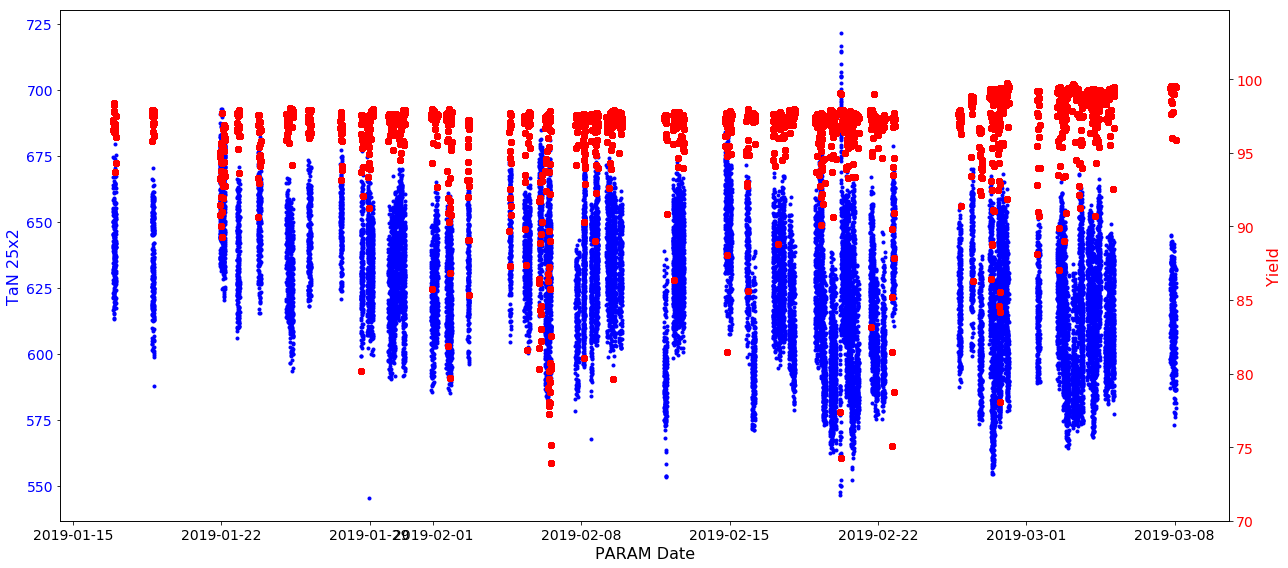

In [61]:
fig, ax1 = plt.subplots(figsize=(18,8))

color = 'blue'
ax1.set_xlabel('PARAM Date', fontsize=16)
ax1.set_ylabel('TaN 25x2', color=color, fontsize=16)
ax1.plot(PCM_YE['PARAM_DATE'], PCM_YE['TAN_25X2'],'b.')
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Yield', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.plot(PCM_YE['PARAM_DATE'], PCM_YE['Yield'],'ro')
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)
ax2.set_ylim(bottom=70)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


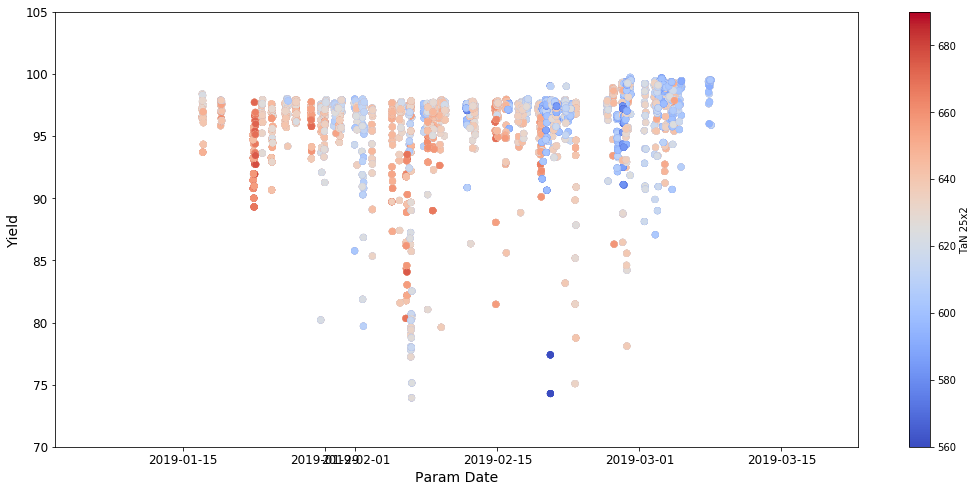

In [54]:
fig2=plt.figure(figsize=(18,8))
plt.scatter(x=list(PCM_YE['PARAM_DATE']), y=list(PCM_YE['Yield']),c=list(PCM_YE['TAN_25X2']),cmap='coolwarm')
plt.ylim(70, 105)
plt.ylabel('Yield', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Param Date', fontsize=14)
plt.xticks(fontsize=12)
plt.clim(560, 690)
plt.colorbar(label='TaN 25x2')
plt.show()